# PG Fixed evader trajectory (generalization)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import optim
from models import pursuer_NN

from random import sample

print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

3.9.7 (default, Sep 10 2021, 14:59:43) 
[GCC 11.2.0]
1.9.1+cu111
11.1
cuda


## Environment

In [2]:
from environment import Environment

sel_env = 1
res = 1

env_file = open('Env'+str(sel_env)+'_res'+str(res)+'.txt', 'r')
env_head = np.fromstring(env_file.readline(), dtype=np.int32, sep=' ')
env_file.close()

env = Environment(env_head, device)
print('Max reward', env.t_end+1)

Max reward 33


## Training initial states selection

In [3]:
initial_states = env.train_configurations(10)
print(len(initial_states))

160


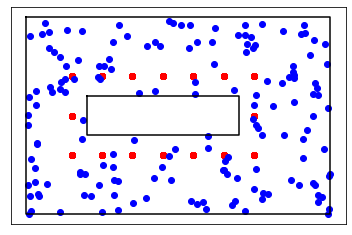

In [4]:
from obstacles import obstacles_per_env, border_per_env
border = border_per_env(sel_env)
obs = obstacles_per_env(sel_env)

border_x = []
border_y = []
for ver in border.vertices:
    border_x.append(ver.y)
    border_y.append(-ver.x)
border_x.append(border.vertices[0].y)
border_y.append(-border.vertices[0].x)

initial_states_array = np.array(initial_states)

ey = -initial_states_array[:,0]
ex = initial_states_array[:,1]
py = -initial_states_array[:,2]
px = initial_states_array[:,3]

if sel_env == 3: plt.figure(figsize=(15,15))
plt.scatter(ex, ey, c='red')
plt.scatter(px, py, c='blue')

plt.plot(border_x, border_y, 'k')
for ob in obs:
    ob_x = []
    ob_y = []
    
    for ver in ob.vertices:
        ob_x.append(ver.y)
        ob_y.append(-ver.x)
    ob_x.append(ob.vertices[0].y)
    ob_y.append(-ob.vertices[0].x)

    plt.plot(ob_x, ob_y, 'k')
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.savefig('train_samples' + str(sel_env) + '.png')
plt.show()

## Evaluation Initial States

In [5]:
eval_initial_states = []
if sel_env == 1:
    eval_initial_states.append( np.array([1.5,1.5, 0.5,0.5]) )
    eval_initial_states.append( np.array([1.5,5.5, 1.5,3.5]) )
    eval_initial_states.append( np.array([1.5,7.5, 0.5,9.5]) )
    eval_initial_states.append( np.array([3.5,7.5, 4.5,9.5]) )
    eval_initial_states.append( np.array([3.5,4.5, 4.5,2.5]) )
    eval_initial_states.append( np.array([3.5,1.5, 3.5,5.5]) )
elif sel_env == 3:
    eval_initial_states.append(np.array([1.5, 1.5, 0.5, 0.5]))
    eval_initial_states.append(np.array([1.5, 4.5, 4.5, 5.5]))
    eval_initial_states.append(np.array([0.5, 6.5, 2.5, 5.5]))
    eval_initial_states.append(np.array([1.5, 9.5, 0.5, 9.5]))
    eval_initial_states.append(np.array([11.5, 9.5, 12.5, 10.5]))
    eval_initial_states.append(np.array([12.5, 4.5, 13.5, 2.5]))
    eval_initial_states.append(np.array([5.5, 0.5, 6.5, 1.5]))

print(eval_initial_states)

[array([1.5, 1.5, 0.5, 0.5]), array([1.5, 5.5, 1.5, 3.5]), array([1.5, 7.5, 0.5, 9.5]), array([3.5, 7.5, 4.5, 9.5]), array([3.5, 4.5, 4.5, 2.5]), array([3.5, 1.5, 3.5, 5.5])]


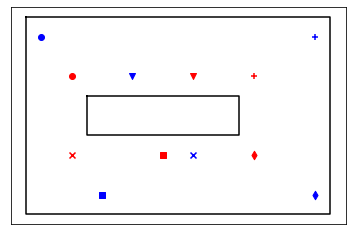

In [6]:
from obstacles import obstacles_per_env, border_per_env
border = border_per_env(sel_env)
obs = obstacles_per_env(sel_env)

border_x = []
border_y = []
for ver in border.vertices:
    border_x.append(ver.y)
    border_y.append(-ver.x)
border_x.append(border.vertices[0].y)
border_y.append(-border.vertices[0].x)

initial_states_array = np.array(eval_initial_states)

ey = -initial_states_array[:,0]
ex = initial_states_array[:,1]
py = -initial_states_array[:,2]
px = initial_states_array[:,3]

if sel_env == 3: plt.figure(figsize=(15,15))
my_markers = ['o', 'v', '+', 'd', 's', 'x', '*']
for i in range(len(initial_states_array)):
    evader = chr(i)
    plt.scatter(ex[i], ey[i], c='red', marker=my_markers[i])
    plt.scatter(px[i], py[i], c='blue', marker=my_markers[i])

plt.plot(border_x, border_y, 'k')
for ob in obs:
    ob_x = []
    ob_y = []
    
    for ver in ob.vertices:
        ob_x.append(ver.y)
        ob_y.append(-ver.x)
    ob_x.append(ob.vertices[0].y)
    ob_y.append(-ob.vertices[0].x)

    plt.plot(ob_x, ob_y, 'k')
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.savefig('test_samples' + str(sel_env) + '.png')
plt.show()

## Create fully connected network

In [7]:
pursuer_model_training_simple  = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)
pursuer_model_simple = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)

In [8]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])

    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]

    return r#(r - r.mean())# / (r.std() + np.finfo(np.float32).eps)

In [9]:
def REINFORCE(total_trajectories=2000, gamma=0.9, lr=0.0001, batch_size=12, MAX_EPSILON=1.0, MIN_EPSILON=0.1, DECAY_RATE=0.001):

    total_batches = total_trajectories // batch_size
    # Set up lists to hold results
    train_rewards  = []
    train_rewards.append(0)
    test_rewards   = []
    test_rewards.append(np.zeros(len(eval_initial_states)))
    avg_test_rewards = []
    avg_test_rewards.append(0)
    test_episodes  = []
    test_episodes.append(0)

    optimizer = optim.Adam(pursuer_model_training_simple.parameters(), lr=lr)

    for ep in range(total_batches):
        batch_states            = []
        batch_discount_rewards  = []
        batch_total_rewards     = []
        batch_actions           = []

        # Random select initial states of length batch_size
        batch_initial_states = sample(initial_states, batch_size)

        index = 0
        for s_0 in batch_initial_states:
            num_traj = ep*batch_size + index
            index += 1
            env.set_state(s_0)

            states  = []
            actions = []
            rewards = []

            done = False
            t = 0
            while not done:
                p_dist = pursuer_model_training_simple(s_0).detach().cpu().numpy()

                epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * num_traj)
                s_1, r, done, a_p = env.step_training(p_dist, t, epsilon=epsilon)
                
                states.append(s_0)
                rewards.append(r)
                actions.append(a_p)

                t += 1
                s_0 = s_1

            batch_states.extend(states)
            batch_discount_rewards.extend(discount_rewards(rewards, gamma))
            batch_total_rewards.append(sum(rewards))
            batch_actions.extend(actions)
        train_rewards.append(np.mean(batch_total_rewards))

        optimizer.zero_grad()
        
        state_tensor  = torch.FloatTensor(batch_states)
        reward_tensor = torch.FloatTensor(batch_discount_rewards).to(device)
        action_tensor = torch.LongTensor(batch_actions)

        # Calculate loss
        logprob             = torch.log(pursuer_model_training_simple(state_tensor)).to(device)
        selected_logprobs   = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        loss                = -selected_logprobs.mean()

        # Calculate and apply gradients
        loss.backward()
        optimizer.step()

        # Use best actions with all initial states
        batch_test_rewards = np.zeros(len(eval_initial_states))
        for i in range(len(eval_initial_states)):
            s_0 = eval_initial_states[i]
            env.set_state(s_0)
            done = False
            t = 0
            while not done:
                p_dist = pursuer_model_training_simple(s_0).detach().cpu().numpy()
                s_0, r, done, _ = env.step_best_action(p_dist, t)
                batch_test_rewards[i] += r
                t += 1
        
        if np.mean(batch_test_rewards) >= avg_test_rewards[-1]:
            pursuer_model_simple.load_state_dict(pursuer_model_training_simple.state_dict())
            avg_test_rewards.append(np.mean(batch_test_rewards))
            test_rewards.append(batch_test_rewards)
        else:
            avg_test_rewards.append(avg_test_rewards[-1])
            test_rewards.append(test_rewards[-1])
            
        test_episodes.append(ep * batch_size)

        print('\rEp {}, number of trajectories {}, average training rewards {:.4f}, average test rewards {:.4f}'\
                .format(ep, test_episodes[-1], train_rewards[-1], avg_test_rewards[-1]),)# end='')

    return test_episodes, train_rewards, test_rewards, avg_test_rewards

In [10]:
test_episodes, train_rewards_simple, test_rewards_simple, avg_test_rewards_simple = REINFORCE(total_trajectories=12000, batch_size=12, lr=0.0005, MIN_EPSILON=0.1, gamma=0.99)

Ep 0, number of trajectories 0, average training rewards 5.7500, average test rewards 5.1667
Ep 1, number of trajectories 12, average training rewards 2.5833, average test rewards 5.1667
Ep 2, number of trajectories 24, average training rewards 4.5833, average test rewards 5.1667
Ep 3, number of trajectories 36, average training rewards 3.0833, average test rewards 5.1667
Ep 4, number of trajectories 48, average training rewards 3.9167, average test rewards 5.1667
Ep 5, number of trajectories 60, average training rewards 3.9167, average test rewards 5.1667
Ep 6, number of trajectories 72, average training rewards 4.6667, average test rewards 5.1667
Ep 7, number of trajectories 84, average training rewards 3.6667, average test rewards 5.1667
Ep 8, number of trajectories 96, average training rewards 3.4167, average test rewards 5.1667
Ep 9, number of trajectories 108, average training rewards 4.4167, average test rewards 5.1667
Ep 10, number of trajectories 120, average training rewards 

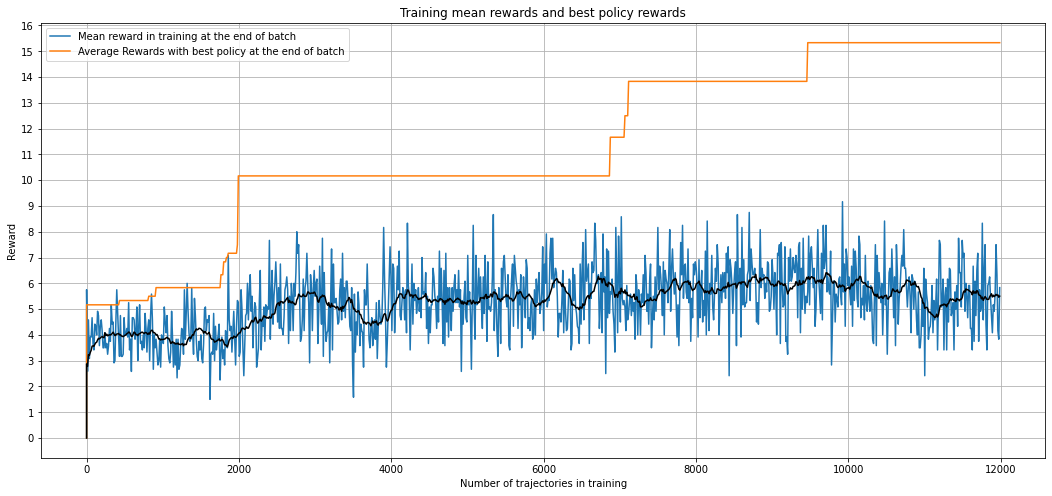

In [11]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(test_episodes, train_rewards_simple, label='Mean reward in training at the end of batch')
plt.plot(test_episodes, avg_test_rewards_simple, label='Average Rewards with best policy at the end of batch')

window = 20
smoothed_train_rewards = [np.mean(train_rewards_simple[i-window:i+1]) if i > window 
                    else np.mean(train_rewards_simple[:i+1]) for i in range(len(train_rewards_simple))]
plt.plot(test_episodes, smoothed_train_rewards, 'k')

plt.xlabel('Number of trajectories in training')
plt.ylabel('Reward')
plt.title('Training mean rewards and best policy rewards')
plt.legend()
#grid
yticks = np.linspace(0, int(max(avg_test_rewards_simple))+1, int(max(avg_test_rewards_simple))+2)
ax.set_yticks(yticks)
plt.grid()
plt.savefig('pursuer_' + str(sel_env) + '.png')
plt.show()

In [12]:
array_test_rewards_simple = np.array(test_rewards_simple)
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_episodes.txt', test_episodes, fmt='%.4f')
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_train_rewrds.txt', train_rewards_simple, fmt='%.4f')
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_test_rewards.txt', array_test_rewards_simple, fmt='%.4f')

np.savetxt('pursuer_RL_Env' + str(sel_env) + '_avg_test_rewards.txt', avg_test_rewards_simple, fmt='%.4f')

In [13]:
torch.save(pursuer_model_simple,  'pursuer_RL_Env' + str(sel_env) + '.pt')
torch.save(pursuer_model_simple.state_dict(),  'pursuer_dict_RL_Env' + str(sel_env) + '.pt')

# PG Fixed evader trajectory (generalization) with initialization

## Create fully connected network

In [14]:
pursuer_model_training_init = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)
pursuer_model_training_init.load_state_dict(torch.load('pursuer_dict_NN_Env'+str(sel_env)+'_res'+str(res)+'.pt'))

pursuer_model_init = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)

In [15]:
def REINFORCE_init(total_trajectories=2000, gamma=0.9, lr=0.0001, batch_size=12, MAX_EPSILON=1.0, MIN_EPSILON=0.1, DECAY_RATE=0.001):

    total_batches = total_trajectories // batch_size
    # Set up lists to hold results
    train_rewards  = []
    train_rewards.append(0)
    test_rewards   = []
    test_rewards.append(np.zeros(len(eval_initial_states)))
    avg_test_rewards = []
    avg_test_rewards.append(0)
    test_episodes  = []
    test_episodes.append(0)

    optimizer = optim.Adam(pursuer_model_training_init.parameters(), lr=lr)

    for ep in range(total_batches):
        batch_states            = []
        batch_discount_rewards  = []
        batch_total_rewards     = []
        batch_actions           = []

        # Random select initial states of length batch_size
        batch_initial_states = sample(initial_states, batch_size)

        index = 0
        for s_0 in batch_initial_states:
            num_traj = ep*batch_size + index
            index += 1
            env.set_state(s_0)

            states  = []
            actions = []
            rewards = []

            done = False
            t = 0
            while not done:
                p_dist = pursuer_model_training_init(s_0).detach().cpu().numpy()

                epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * num_traj)
                s_1, r, done, a_p = env.step_training(p_dist, t, epsilon=epsilon)
                
                states.append(s_0)
                rewards.append(r)
                actions.append(a_p)

                t += 1
                s_0 = s_1

            batch_states.extend(states)
            batch_discount_rewards.extend(discount_rewards(rewards, gamma))
            batch_total_rewards.append(sum(rewards))
            batch_actions.extend(actions)
        train_rewards.append(np.mean(batch_total_rewards))

        optimizer.zero_grad()
        
        state_tensor  = torch.FloatTensor(batch_states)
        reward_tensor = torch.FloatTensor(batch_discount_rewards).to(device)
        action_tensor = torch.LongTensor(batch_actions)

        # Calculate loss
        logprob             = torch.log(pursuer_model_training_init(state_tensor)).to(device)
        selected_logprobs   = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        loss                = -selected_logprobs.mean()

        # Calculate and apply gradients
        loss.backward()
        optimizer.step()

        # Use best actions with all initial states
        batch_test_rewards = np.zeros(len(eval_initial_states))
        for i in range(len(eval_initial_states)):
            s_0 = eval_initial_states[i]
            env.set_state(s_0)
            done = False
            t = 0
            while not done:
                p_dist = pursuer_model_training_init(s_0).detach().cpu().numpy()
                s_0, r, done, _ = env.step_best_action(p_dist, t)
                batch_test_rewards[i] += r
                t += 1
        
        if np.mean(batch_test_rewards) >= avg_test_rewards[-1]:
            pursuer_model_init.load_state_dict(pursuer_model_training_init.state_dict())
            avg_test_rewards.append(np.mean(batch_test_rewards))
            test_rewards.append(batch_test_rewards)
        else:
            avg_test_rewards.append(avg_test_rewards[-1])
            test_rewards.append(test_rewards[-1])
            
        test_episodes.append(ep * batch_size)

        print('\rEp {}, number of trajectories {}, average training rewards {:.4f}, average test rewards {:.4f}'\
                .format(ep, test_episodes[-1], train_rewards[-1], avg_test_rewards[-1]),)# end='')

    return test_episodes, train_rewards, test_rewards, avg_test_rewards

In [16]:
test_episodes, train_rewards_init, test_rewards_init, avg_test_rewards_init = REINFORCE_init(total_trajectories=12000, batch_size=12, lr=0.0005, MIN_EPSILON=0.1, gamma=0.99)

Ep 0, number of trajectories 0, average training rewards 4.0833, average test rewards 5.5000
Ep 1, number of trajectories 12, average training rewards 4.0000, average test rewards 5.5000
Ep 2, number of trajectories 24, average training rewards 5.1667, average test rewards 5.5000
Ep 3, number of trajectories 36, average training rewards 3.7500, average test rewards 5.5000
Ep 4, number of trajectories 48, average training rewards 5.3333, average test rewards 5.5000
Ep 5, number of trajectories 60, average training rewards 3.3333, average test rewards 5.5000
Ep 6, number of trajectories 72, average training rewards 4.5833, average test rewards 5.5000
Ep 7, number of trajectories 84, average training rewards 4.3333, average test rewards 5.6667
Ep 8, number of trajectories 96, average training rewards 2.9167, average test rewards 5.6667
Ep 9, number of trajectories 108, average training rewards 3.4167, average test rewards 5.6667
Ep 10, number of trajectories 120, average training rewards 

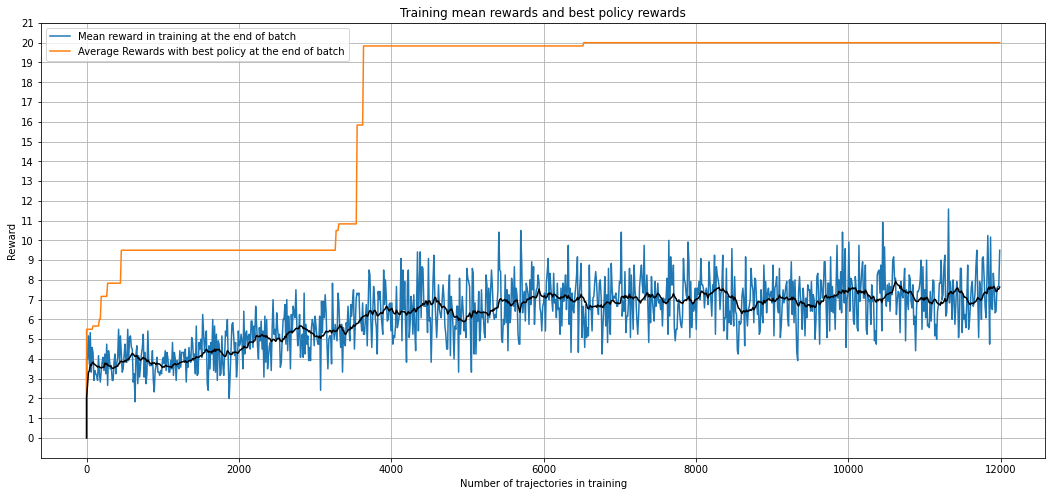

In [17]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(test_episodes, train_rewards_init, label='Mean reward in training at the end of batch')
plt.plot(test_episodes, avg_test_rewards_init, label='Average Rewards with best policy at the end of batch')

window = 20
smoothed_train_rewards = [np.mean(train_rewards_init[i-window:i+1]) if i > window 
                    else np.mean(train_rewards_init[:i+1]) for i in range(len(train_rewards_init))]
plt.plot(test_episodes, smoothed_train_rewards, 'k')

plt.xlabel('Number of trajectories in training')
plt.ylabel('Reward')
plt.title('Training mean rewards and best policy rewards')
plt.legend()
#grid
yticks = np.linspace(0, int(max(avg_test_rewards_init))+1, int(max(avg_test_rewards_init))+2)
ax.set_yticks(yticks)
plt.grid()
plt.savefig('pursuer_initialization_' + str(sel_env) + '.png')
plt.show()

In [18]:
array_test_rewards_init = np.array(test_rewards_init)
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_episodes_initialization.txt', test_episodes, fmt='%.4f')
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_train_rewards_initialization.txt', train_rewards_init, fmt='%.4f')
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_test_rewards_initialization.txt', array_test_rewards_init, fmt='%.4f')

np.savetxt('pursuer_RL_Env' + str(sel_env) + '_avg_test_rewards_initialization.txt', avg_test_rewards_init, fmt='%.4f')

torch.save(pursuer_model_init,  'pursuer_RL_Env' + str(sel_env) + '_initialization.pt')
torch.save(pursuer_model_init.state_dict(),  'pursuer_dict_RL_Env' + str(sel_env) + '_initialization.pt')

# PG Fixed evader trajectory (generalization) with Master assistance

## Create fully connected network

In [19]:
pursuer_model_training_master      = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)
pursuer_model_master               = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)

master  = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)
master  = torch.load('pursuer_NN_Env'+str(sel_env)+'_res'+str(res)+'.pt')
master.eval()

pursuer_NN(
  (predict): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=5, bias=True)
    (9): Softmax(dim=-1)
  )
)

In [20]:
def REINFORCE_master(total_trajectories=2000, gamma=0.9, lr=0.0001, batch_size=12, MAX_EPSILON=1.0, MIN_EPSILON=0.1, DECAY_RATE=0.001):

    total_batches = total_trajectories // batch_size
    # Set up lists to hold results
    train_rewards  = []
    train_rewards.append(0)
    test_rewards   = []
    test_rewards.append(np.zeros(len(eval_initial_states)))
    avg_test_rewards = []
    avg_test_rewards.append(0)
    test_episodes  = []
    test_episodes.append(0)

    optimizer = optim.Adam(pursuer_model_training_master.parameters(), lr=lr)

    for ep in range(total_batches):
        batch_states            = []
        batch_discount_rewards  = []
        batch_total_rewards     = []
        batch_actions           = []

        # Random select initial states of length batch_size
        batch_initial_states = sample(initial_states, batch_size)

        index = 0
        for s_0 in batch_initial_states:
            num_traj = ep*batch_size + index
            index += 1
            env.set_state(s_0)

            states  = []
            actions = []
            rewards = []

            done = False
            t = 0
            
            while not done:
                epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * num_traj)
                if np.random.rand() < epsilon:
                    p_dist = master(s_0).detach().cpu().numpy()
                else:
                    p_dist = pursuer_model_training_master(s_0).detach().cpu().numpy()

                
                s_1, r, done, a_p = env.step_training(p_dist, t)
                
                states.append(s_0)
                rewards.append(r)
                actions.append(a_p)

                t += 1
                s_0 = s_1

            batch_states.extend(states)
            batch_discount_rewards.extend(discount_rewards(rewards, gamma))
            batch_total_rewards.append(sum(rewards))
            batch_actions.extend(actions)
        train_rewards.append(np.mean(batch_total_rewards))

        optimizer.zero_grad()
        
        state_tensor  = torch.FloatTensor(batch_states)
        reward_tensor = torch.FloatTensor(batch_discount_rewards).to(device)
        action_tensor = torch.LongTensor(batch_actions)

        # Calculate loss
        logprob             = torch.log(pursuer_model_training_master(state_tensor)).to(device)
        selected_logprobs   = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        loss                = -selected_logprobs.mean()

        # Calculate and apply gradients
        loss.backward()
        optimizer.step()

        # Use best actions with all initial states
        batch_test_rewards = np.zeros(len(eval_initial_states))
        for i in range(len(eval_initial_states)):
            s_0 = eval_initial_states[i]
            env.set_state(s_0)
            done = False
            t = 0
            while not done:
                p_dist = pursuer_model_training_master(s_0).detach().cpu().numpy()
                s_0, r, done, _ = env.step_best_action(p_dist, t)
                batch_test_rewards[i] += r
                t += 1
        
        if np.mean(batch_test_rewards) >= avg_test_rewards[-1]:
            pursuer_model_master.load_state_dict(pursuer_model_training_master.state_dict())
            avg_test_rewards.append(np.mean(batch_test_rewards))
            test_rewards.append(batch_test_rewards)
        else:
            avg_test_rewards.append(avg_test_rewards[-1])
            test_rewards.append(test_rewards[-1])
            
        test_episodes.append(ep * batch_size)

        print('\rEp {}, number of trajectories {}, average training rewards {:.4f}, average test rewards {:.4f}'\
                .format(ep, test_episodes[-1], train_rewards[-1], avg_test_rewards[-1]),)# end='')

    return test_episodes, train_rewards, test_rewards, avg_test_rewards

In [21]:
test_episodes, train_rewards_master, test_rewards_master, avg_test_rewards_master = REINFORCE_master(total_trajectories=12000, batch_size=12, lr=0.0005, MIN_EPSILON=0.1, gamma=0.99)

Ep 0, number of trajectories 0, average training rewards 4.6667, average test rewards 4.0000
Ep 1, number of trajectories 12, average training rewards 4.4167, average test rewards 4.0000
Ep 2, number of trajectories 24, average training rewards 3.5833, average test rewards 4.0000
Ep 3, number of trajectories 36, average training rewards 4.2500, average test rewards 4.0000
Ep 4, number of trajectories 48, average training rewards 4.6667, average test rewards 4.0000
Ep 5, number of trajectories 60, average training rewards 3.6667, average test rewards 4.0000
Ep 6, number of trajectories 72, average training rewards 4.3333, average test rewards 4.0000
Ep 7, number of trajectories 84, average training rewards 3.3333, average test rewards 4.0000
Ep 8, number of trajectories 96, average training rewards 3.9167, average test rewards 4.0000
Ep 9, number of trajectories 108, average training rewards 4.0000, average test rewards 4.0000
Ep 10, number of trajectories 120, average training rewards 

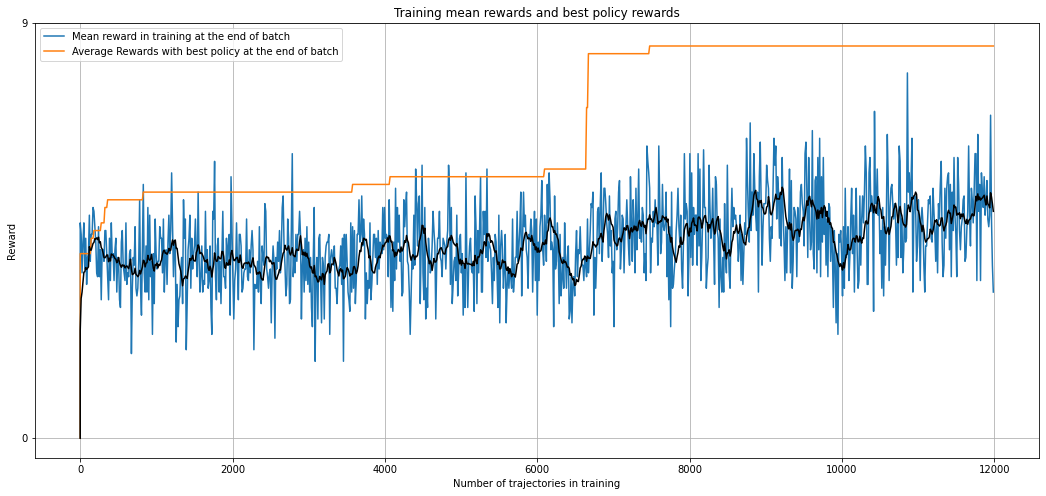

In [22]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(test_episodes, train_rewards_master, label='Mean reward in training at the end of batch')
plt.plot(test_episodes, avg_test_rewards_master, label='Average Rewards with best policy at the end of batch')

window = 10
smoothed_train_rewards = [np.mean(train_rewards_master[i-window:i+1]) if i > window 
                    else np.mean(train_rewards_master[:i+1]) for i in range(len(train_rewards_master))]
plt.plot(test_episodes, smoothed_train_rewards, 'k')

plt.xlabel('Number of trajectories in training')
plt.ylabel('Reward')
plt.title('Training mean rewards and best policy rewards')
plt.legend()
#grid
yticks = np.linspace(0, int(max(avg_test_rewards_master))+1, (int(max(avg_test_rewards_master))+2)//4)
ax.set_yticks(yticks)
plt.grid()
plt.savefig('pursuer_master_' + str(sel_env) + '.png')
plt.show()

In [23]:
array_test_rewards_master = np.array(test_rewards_master)

np.savetxt('pursuer_RL_Env' + str(sel_env) + '_episodes_master.txt', test_episodes, fmt='%.4f')
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_train_rewards_master.txt', train_rewards_master, fmt='%.4f')
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_test_rewards_master.txt', array_test_rewards_master, fmt='%.4f')

np.savetxt('pursuer_RL_Env' + str(sel_env) + '_avg_test_rewards_master.txt', avg_test_rewards_master, fmt='%.4f')

torch.save(pursuer_model_master,  'pursuer_RL_Env' + str(sel_env) + '_master.pt')
torch.save(pursuer_model_master.state_dict(),  'pursuer_dict_RL_Env' + str(sel_env) + '_master.pt')